### Image Interence 

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
net = cv.dnn.readNetFromTensorflow('M:\\yolo\\graph_opt.pb')

In [3]:
thr = 0.2
inWidth = 368
inHeight = 368

In [4]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [5]:
img = cv.imread("M:\\yolo\\input_pose.jpg")

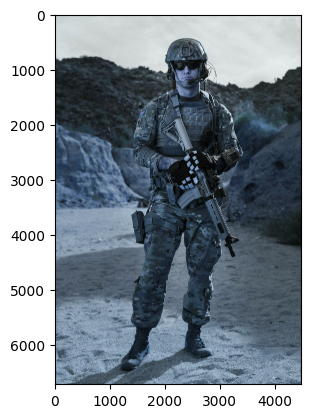

In [6]:
plt.imshow(img) #BGR

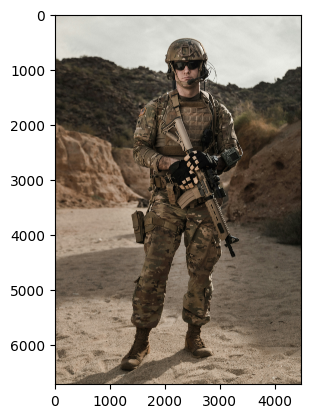

In [7]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))#bgr

In [8]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    return frame

In [9]:
estimated_image = pose_estimation(img)

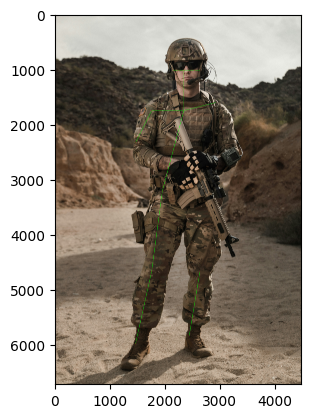

In [10]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

### Video Inference

In [ ]:
import cv2 as cv
import numpy as np
import argparse

# Argument parser for command line input
parser = argparse.ArgumentParser(description='Pose and Object Detection using OpenCV and YOLO.')
parser.add_argument('--input', type=str, help='Path to the input video file.')
parser.add_argument('--output', type=str, help='Path to the output video file.')
args = parser.parse_args()

# Paths to the input and output files
input_file = "M:\\yolo\\4228801-hd_1920_1080_24fps (1).mp4"#path to the input video
output_file = "M:\\yolo\\output.avi"#path to the output video
pose_model = "M:\\yolo\\graph_opt.pb"  # Ensure this model is uploaded
yolo_config = "M:\\yolo\\yolov3.cfg"  # Ensure this model is uploaded
yolo_weights = "M:\\yolo\\yolov3.weights"  # Ensure this model is uploaded
yolo_names = "M:\\yolo\\coco.names"  # Ensure this model is uploaded


# Load the pose estimation model
net_pose = cv.dnn.readNetFromTensorflow(pose_model)

# Load YOLO model
net_yolo = cv.dnn.readNet(yolo_weights, yolo_config)
with open(yolo_names, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net_yolo.getLayerNames()

# Adjust this part to handle different shapes of getUnconnectedOutLayers() return value
try:
    output_layers = [layer_names[i - 1] for i in net_yolo.getUnconnectedOutLayers().flatten()]
except:
    output_layers = [layer_names[i[0] - 1] for i in net_yolo.getUnconnectedOutLayers()]

# Open the video file
cap = cv.VideoCapture(input_file)
cap.set(3, 800)
cap.set(4, 800)

if not cap.isOpened():
    raise IOError("Cannot Open Video")

# Prepare output video writer
fourcc = cv.VideoWriter_fourcc(*'XVID')
out_video = cv.VideoWriter(output_file, fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while True:
    hasFrame, frame = cap.read()
    if not hasFrame:
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # YOLO Object Detection
    blob = cv.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net_yolo.setInput(blob)
    outs = net_yolo.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                w = int(detection[2] * frameWidth)
                h = int(detection[3] * frameHeight)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (0, 255, 0)
            cv.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv.putText(frame, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Pose Detection
    net_pose.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out_pose = net_pose.forward()
    out_pose = out_pose[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert len(BODY_PARTS) == out_pose.shape[1]

    points = []
    for i in range(len(BODY_PARTS)):
        heatMap = out_pose[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out_pose.shape[3]
        y = (frameHeight * point[1]) / out_pose.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert partFrom in BODY_PARTS
        assert partTo in BODY_PARTS

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net_pose.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    out_video.write(frame)

cap.release()
out_video.release()
cv.destroyAllWindows()


### WebCam Interence

In [11]:
import cv2 as cv
import numpy as np



# Load YOLO model
yolo_config = "yolov3.cfg"
yolo_weights = "yolov3.weights"
yolo_names = "coco.names"

net_yolo = cv.dnn.readNet(yolo_weights, yolo_config)
with open(yolo_names, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net_yolo.getLayerNames()

try:
    output_layers = [layer_names[i - 1] for i in net_yolo.getUnconnectedOutLayers().flatten()]
except:
    output_layers = [layer_names[i[0] - 1] for i in net_yolo.getUnconnectedOutLayers()]

# Open the webcam feed
cap = cv.VideoCapture(0)
cap.set(3, 800)
cap.set(4, 800)

if not cap.isOpened():
    raise IOError("Cannot Open Webcam")

while True:
    hasFrame, frame = cap.read()
    if not hasFrame:
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    # YOLO Object Detection
    blob = cv.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net_yolo.setInput(blob)
    outs = net_yolo.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                w = int(detection[2] * frameWidth)
                h = int(detection[3] * frameHeight)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (0, 255, 0)
            cv.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv.putText(frame, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Pose Detection
    net_pose.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out_pose = net_pose.forward()
    out_pose = out_pose[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert len(BODY_PARTS) == out_pose.shape[1]

    points = []
    for i in range(len(BODY_PARTS)):
        heatMap = out_pose[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out_pose.shape[3]
        y = (frameHeight * point[1]) / out_pose.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert partFrom in BODY_PARTS
        assert partTo in BODY_PARTS

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net_pose.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    cv.imshow('Pose and Object Detection', frame)

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()
